<a href="https://colab.research.google.com/github/minghui-i/brain_cancer_edge_detection/blob/main/brain_cancer_edge_detection_load_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from time import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
class FramesDataset(Dataset):
  def __init__(self, data_pd):
    self.data_pd = data_pd

  def __len__(self):
    return len(self.data_pd)

  def __getitem__(self, index):
    return self.data_pd.iloc[index]['Tensor'], self.data_pd.iloc[index]['Label']

In [ ]:
def edge_detection(image_path):

    print(os.path.exists(image_path))

    # Read the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, threshold1=10, threshold2=50)

    image = Image.fromarray(edges)

    return image

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 2)
        self.conv2 = nn.Conv2d(4, 16, 5, 2)
        self.fc1 = nn.Linear(576, 550)
        self.fc2 = nn.Linear(550, 540)
        self.fc3 = nn.Linear(540, 470)
        self.fc4 = nn.Linear(470, 300)
        self.fc5 = nn.Linear(300, 220)
        self.fc6 = nn.Linear(220, 130)
        self.fc7 = nn.Linear(130, 70)
        self.fc8 = nn.Linear(70, 40)
        self.fc9 = nn.Linear(40, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3, 3)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        return x

True


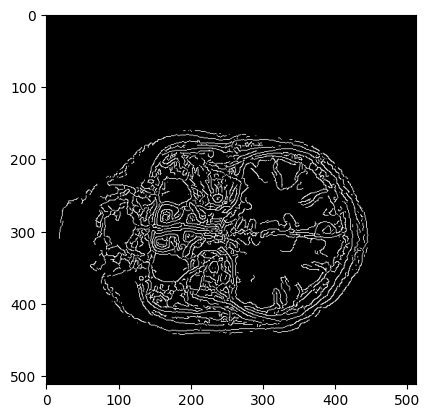

In [ ]:
transform = Compose((Resize((256, 256)), Grayscale(), ToTensor()))

imagePath = r'/content/brain_menin_4562.jpg'
edgeImage = edge_detection(imagePath)

plt.imshow(edgeImage, cmap='gray')
plt.show()

tensor = [transform(edgeImage)]
label = [1]

data = {'Tensor': tensor, 'Label': label}
df = pd.DataFrame(data)

dataset = FramesDataset(df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = CNN()
old_model_dict = torch.load('/content/drive/MyDrive/CancerDetection/savedmodels/edgemodel1.pt')
new_model_dict = {}
for key, value in old_model_dict.items():
  new_model_dict[key.replace('_orig_mod.', '')] = value
model.load_state_dict(new_model_dict)
model.eval()

CNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=576, out_features=550, bias=True)
  (fc2): Linear(in_features=550, out_features=540, bias=True)
  (fc3): Linear(in_features=540, out_features=470, bias=True)
  (fc4): Linear(in_features=470, out_features=300, bias=True)
  (fc5): Linear(in_features=300, out_features=220, bias=True)
  (fc6): Linear(in_features=220, out_features=130, bias=True)
  (fc7): Linear(in_features=130, out_features=70, bias=True)
  (fc8): Linear(in_features=70, out_features=40, bias=True)
  (fc9): Linear(in_features=40, out_features=3, bias=True)
)

In [ ]:
predictions = []
labels = []

with torch.no_grad():

    model.eval()

    for batch_idx, (data, targets) in enumerate(dataloader):

        model.to(device)
        outputs = model(data.to(device))
        # print(outputs)

        probabilities_batch = F.softmax(outputs, dim=1)

        print(probabilities_batch)

        predicted, _ = torch.max(probabilities_batch, 1)
        print(_)
        print(len(_))
        print(len(predicted))
        print(predicted[0])

        for i in range(len(_)):
          if _[i] == 0:
            predictions.append(0)
          elif _[i] == 1:
            predictions.append(1)
          else:
            predictions.append(2)

        labels.extend(targets.cpu().numpy())


        print(predictions)
        print(labels)


tensor([[0.2550, 0.4181, 0.3269]], device='cuda:0')
tensor([1], device='cuda:0')
1
1
tensor(0.4181, device='cuda:0')
[1]
[np.int64(1)]


In [ ]:
print(accuracy_score(labels, predictions))
print(confusion_matrix(labels, predictions))
print(classification_report(labels, predictions))

1.0
[[1]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
